In [1]:
import scanpy as sc
import numpy as np
from scar import model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab

In [2]:
adata = sc.read_h5ad("/home/chang/barcode_data.h5")

In [3]:
adata

AnnData object with n_obs × n_vars = 30000 × 66833
    obs: 'Sample', 'Barcode', 'is_cell'
    var: 'ID'
    uns: 'X_name'

In [4]:
adata.obs.is_cell.value_counts()

False    18893
True     11107
Name: is_cell, dtype: int64

In [5]:
mk = np.in1d(adata.var_names.values.astype(str), "unmapped")
adata = adata[:,~mk]
adata

View of AnnData object with n_obs × n_vars = 30000 × 66832
    obs: 'Sample', 'Barcode', 'is_cell'
    var: 'ID'
    uns: 'X_name'

In [6]:
ambient = adata[adata.obs.is_cell == False,]
ambient

View of AnnData object with n_obs × n_vars = 18893 × 66832
    obs: 'Sample', 'Barcode', 'is_cell'
    var: 'ID'
    uns: 'X_name'

In [7]:
cell_free = ambient.to_df()
ambient_profile = cell_free.sum()/cell_free.sum().sum()
ambient_profile = ambient_profile.to_frame("ambient profile")
ambient_profile

,ambient profile
BC1-CAGTGTACCAACCATGCTCAGGTAGCCTCACCTCCTGCAGTCAGTACACCAGTCATGTGCAACAC,0.000000
BC2-TGGTGTGTCAACGTTGCTCAGGTAGCCTCACCTCCCAACTGCAGTACACTGACCAGTCATGCACA,0.000000
BC3-ACGTGTTGTGGTCATGCTCAGGTAGCCTCACCTCCGTGTACACACGTTGTGCAACACTGTGCAGT,0.000000
BC4-CAGTGTTGTGCAACTGCTCAGGTAGCCTCACCTCCGTACCACATGCATGACGTGTACGTCACAGT,0.000006
BC5-TGGTGTCAGTGTTGTGCTCAGGTAGCCTCACCTCCACGTGTGTGTACACACCAGTCACATGGTTG,0.000000
...,...
BC66828-CAGTGTACACCAACTGCTCAGGTAGCCTCACCTCCTGGTACACACCAGTTGTGCATGCAACGTAC,0.000002
BC66829-CAGTGTACCAACCATGCTCAGGTAGCCTCACCTCCCACAACTGTGGTGTTGTGACACGTTGACCA,0.000000
BC66830-CAGTGTACGTTGACTGCTCAGGTAGCCTCACCTCCACGTCACAGTTGGTTGTGGTACGTACTGTG,0.000000
BC66831-TGGTGTTGCAGTGTTGCTCAGGTAGCCTCACCTCCACGTCAACTGGTACCAACCATGCACAACTG,0.000000


In [8]:
cells = adata[adata.obs.is_cell == True,]
cells

View of AnnData object with n_obs × n_vars = 11107 × 66832
    obs: 'Sample', 'Barcode', 'is_cell'
    var: 'ID'
    uns: 'X_name'

In [10]:
bcs = model(raw_count = cells.to_df(),
               ambient_profile = ambient_profile,
               feature_type = 'sgRNAs')

bcs.train(epochs=100,
             batch_size=64,
             verbose=True
          )
bcs.inference(cutoff=3)

..Running VAE using the following param set:
......denoised count type:  sgRNAs
......count model:  binomial
......num_input_feature:  66832
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......expected data sparsity:  1
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:13<00:00, 28.34s/it]
  Inferring .....


In [11]:
bcs.feature_assignment

,sgRNAs,n_sgRNAs
0,BC29437-CAGTGTCAACACGTTGCTCAGGTAGCCTCACCTCCCAA...,1
1,BC50292-TGGTGTCAGTCACATGCTCAGGTAGCCTCACCTCCTGC...,1
2,BC20919-ACGTGTTGTGGTCATGCTCAGGTAGCCTCACCTCCACC...,1
4,BC15293-ACGTGTCAGTACACTGCTCAGGTAGCCTCACCTCCACC...,1
7,BC51336-CAGTGTACGTTGACTGCTCAGGTAGCCTCACCTCCGTA...,1
...,...,...
29989,BC11705-GTGTGTACGTCAGTTGCTCAGGTAGCCTCACCTCCTGC...,1
29994,BC13130-CAGTGTGTCAACTGTGCTCAGGTAGCCTCACCTCCCAC...,1
29995,BC29437-CAGTGTCAACACGTTGCTCAGGTAGCCTCACCTCCCAA...,1
29997,BC51257-CAGTGTCAACCACATGCTCAGGTAGCCTCACCTCCACC...,1


In [37]:
cells.obs["BC"] = bcs.feature_assignment.sgRNAs
cells.obs["unique_BC"] = bcs.feature_assignment.n_sgRNAs
cells.obs["unique_BC"] = pd.to_numeric(cells.obs["unique_BC"])
cells.obs

,Sample,Barcode,is_cell,BC,unique_BC
0,/gstore/scratch/u/garfield/trace_seq_test/cite...,CTGAATGGTAGATTAG-1,True,BC29437-CAGTGTCAACACGTTGCTCAGGTAGCCTCACCTCCCAA...,1
1,/gstore/scratch/u/garfield/trace_seq_test/cite...,TCGGTCTGTAATTAGG-1,True,BC50292-TGGTGTCAGTCACATGCTCAGGTAGCCTCACCTCCTGC...,1
2,/gstore/scratch/u/garfield/trace_seq_test/cite...,ACTTTGTGTACCCGAC-1,True,BC20919-ACGTGTTGTGGTCATGCTCAGGTAGCCTCACCTCCACC...,1
4,/gstore/scratch/u/garfield/trace_seq_test/cite...,TGGATGTAGTTTAGGA-1,True,BC15293-ACGTGTCAGTACACTGCTCAGGTAGCCTCACCTCCACC...,1
7,/gstore/scratch/u/garfield/trace_seq_test/cite...,GTCACGGTCAGGTGTT-1,True,BC51336-CAGTGTACGTTGACTGCTCAGGTAGCCTCACCTCCGTA...,1
...,...,...,...,...,...
29989,/gstore/scratch/u/garfield/trace_seq_test/cite...,CCAATTTAGTAGGATT-1,True,BC11705-GTGTGTACGTCAGTTGCTCAGGTAGCCTCACCTCCTGC...,1
29994,/gstore/scratch/u/garfield/trace_seq_test/cite...,GAGGCAAGTCGCTCGA-1,True,BC13130-CAGTGTGTCAACTGTGCTCAGGTAGCCTCACCTCCCAC...,1
29995,/gstore/scratch/u/garfield/trace_seq_test/cite...,TGAGTCACAGTATGAA-1,True,BC29437-CAGTGTCAACACGTTGCTCAGGTAGCCTCACCTCCCAA...,1
29997,/gstore/scratch/u/garfield/trace_seq_test/cite...,ATCCCTGCAGAAGCTG-1,True,BC22375-CAGTGTCATGACCATGCTCAGGTAGCCTCACCTCCCAC...,4


In [44]:
cells.write_h5ad("/home/chang/data_scar.h5ad")

In [12]:
params = {'legend.fontsize': 6,
          'legend.title_fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (4, 3),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'axes.grid':False,}

pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");
sns.despine(offset=4, trim=True);

<Figure size 400x300 with 0 Axes>

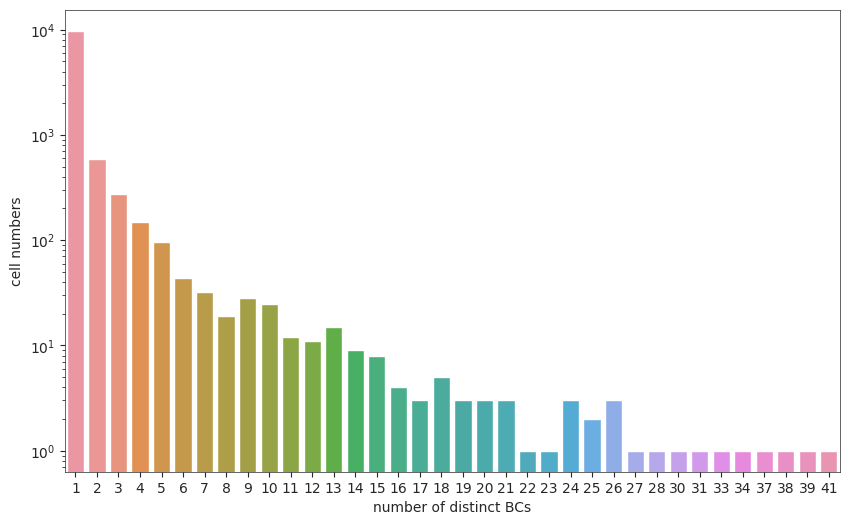

In [24]:
cell_num = bcs.feature_assignment.value_counts("n_sgRNAs").to_frame("cell numbers").reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data = cell_num,
            x = 'n_sgRNAs',
            y = 'cell numbers'
           );
plt.yscale('log',base=10) 
plt.xlabel("number of distinct BCs");


In [50]:
cells.obs.BC.value_counts()[cells.obs.BC.value_counts() > 2]

BC50292-TGGTGTCAGTCACATGCTCAGGTAGCCTCACCTCCTGCAACGTTGTGTGACACTGTGCAACTGAC    127
BC34464-TGGTGTCACAACCATGCTCAGGTAGCCTCACCTCCTGCAGTACTGCAACTGGTGTACCACAGTAC     75
BC8435-CAGTGTACACCAACTGCTCAGGTAGCCTCACCTCCGTCAACTGGTCACATGGTTGACTGACACGT      61
BC52993-CAGTGTCATGACCATGCTCAGGTAGCCTCACCTCCCAGTGTACACCAACACACGTGTGTGTTGTG     58
BC66488-TGGTGTTGCAGTGTTGCTCAGGTAGCCTCACCTCCGTACACACCAGTTGACTGCATGTGACTGAC     58
                                                                            ... 
BC9717-GTGTGTGTTGACACTGCTCAGGTAGCCTCACCTCCACGTTGGTGTACTGACGTCACACAGTCAAC       3
BC3419-CAGTGTGTCAACTGTGCTCAGGTAGCCTCACCTCCACTGGTACCAACTGACTGACACACGTGTCA       3
BC1715-ACGTGTTGACTGCATGCTCAGGTAGCCTCACCTCCACACACCACACACAACGTGTACTGTGACTG       3
BC1407-ACGTGTCACAACGTTGCTCAGGTAGCCTCACCTCCTGGTACACTGCACAGTCAGTCACATGGTTG       3
BC10065-TGGTGTCACAGTACTGCTCAGGTAGCCTCACCTCCGTTGCAACACTGGTCATGCACACATGGTTG      3
Name: BC, Length: 895, dtype: int64